# figure 3 vlz

- kernel: r_env, R 4.1.3
- date: 2023-12-28

## load

In [1]:
library(tidyverse)
library(tools)
library(logging)
library(ggpubr)
library(ggsci)
library(patchwork)
library(igraph)
library(ggraph)
library(Seurat)
library(maftools)
library(ComplexHeatmap)

source('../../stage2/scripts/r_funcs.r')

theme_set(theme_pubr())
logging::basicConfig()
options(warn = -1)

outdir <- '../figures/fig3'
create_dir(outdir)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats

In [2]:
f_pat_gp <- '../tables/patient_info_v2.tsv'
gp <- 'response'
gp_lvls$response <- c('R', 'PR')
gp_comp_map$response <- list(
  c('R-pre', 'R-post'),
  c('PR-pre', 'PR-post'),
  c('R-pre', 'PR-pre'),
  c('R-post', 'PR-post')
)
gp_comp_diff_map$response <- list(c('R', 'PR'))
gp_comp_map_pre$response <- list(c('R-pre', 'PR-pre'))
comb_order <- c('R-pre', 'R-post', 'PR-pre', 'PR-post')

celltype_map <- list(
    'T_MKI67' = c('T_Prolif')
)

## 3a: T cell markers

- 2024-01-02: update gene list

In [23]:
f_seuobj <- '../../stage4/a01_data/seuobj/t.rds'

ctype_order <- c(
    'NK', 'NK_CX3CR1',
    'CD4_CXCL13', 'CD4_KLRB1', 'Treg_LTB', 'Treg_TNFRSF4',
    'CD8_CXCL13', 'CD8_TYMS', # exhau
    'CD8_CD74', 'CD8_IFIT1', # others
    'CD8_ANXA1', 'CD8_CCL5', 'CD8_CX3CR1', 'CD8_FOS', 'CD8_GZMK', 'CD8_KLRB1', # cyto
    'T_MKI67', 'T_Mito', 'T_IL7R', 'T_Ribo'
)
markers <- list(
    'NK profile' = c('NCAM1', 'FCER1G', 'KLRC1', 'TYROBP'),  # NK
    'T profile' = c('CD3E', 'CD4', 'TNFRSF4', 'CD8A', 'CD8B'),  # major markers
    'Treg' = c('FOXP3', 'IKZF2'),
    'Naive/TCM' = c('CCR7', 'SELL', 'TCF7', 'IL7R'),
    'Exhaustion' = c('PDCD1', 'HAVCR2', 'ENTPD1', 'TNFRSF9', 'CXCL13'),  # exhaustion
    'Cytotocity' = c('CST7', 'GZMH', 'GZMK', 'GZMM', 'IFNG', 'PRF1', 'KLRG1', 'NKG7', 'GZMA'), # cyto
    'Resident' = c('CD101', 'CXCR6', 'CD69'),
    'Others' = c('CX3CR1', 'ITGAE', 'MT-ATP6', 'MT-ND3', 'ANXA1', 'CCL5', 'KLRB1', 'MKI67', 'RPL30')
)

In [4]:
scrna <- readRDS(f_seuobj)

In [5]:
# rename cell type
scrna$cell_group <- scrna$subtype
scrna$cell_group[scrna$cell_group == 'T_Prolif'] <- 'T_MKI67'
scrna$cell_group <- factor(scrna$cell_group, levels = ctype_order)

In [25]:
# jp_opt(wd = 14, hg = 5.5)
p <- DotPlot(scrna, group.by = 'cell_group', features = markers) +
    scale_color_gsea() +
    labs(x = '', y = '') +
    theme(axis.text.x = element_text(angle = 60, hjust = 0.95, vjust = 0.95))
ggsave(filename = str_glue('{outdir}/fig3a-dot_t_marker.pdf'), plot = p, width = 14, height = 6)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


## 3b: TCR sharing network

- date: 2024-01-02

In [3]:
f_node <- '../../stage4/a03_tcr/net_vlz_old/net_node_info.csv'
f_edge <- '../../stage4/a03_tcr/net_vlz_old/net_edge_info.csv'

# to rename cell types
celltype_map <- list(
    'T_MKI67' = c('T_Prolif')
)
# to rename cell states (use renamed cell type)
cell_state_map <- list(
    'others' = c('Treg_LTB')
)

df_edge <- read_csv(f_edge, show_col_types = F)
df_node <- read_csv(f_node, show_col_types = F)

In [4]:
# update cell types
for (nm in names(celltype_map)) {
    df_node$node[df_node$node %in% celltype_map[[nm]]] <- nm
    df_edge$from[df_edge$from %in% celltype_map[[nm]]] <- nm
    df_edge$to[df_edge$to %in% celltype_map[[nm]]] <- nm
}
df_edge$edge_type <- paste(df_edge$from, df_edge$to, sep = '->')
# node: update cell states
for (nm in names(cell_state_map)) {
    df_node$node_type[df_node$node %in% cell_state_map[[nm]]] <- nm
}

df_node %>% write_tsv(str_glue('{outdir}/fig3b-net_tcr_sharing-node_info.tsv'))
df_edge %>% write_tsv(str_glue('{outdir}/fig3b-net_tcr_sharing-edge_info.tsv'))

In [5]:
df_node$node_type <- factor(df_node$node_type, levels = c('exhausted', 'cytotoxic', 'dying', 'others'))
p <- exhau_cyto_netplot(df_node = df_node, df_edge = df_edge, color_by = 'node_type', text_size = 4.5, pt_size = 6) +
    scale_color_manual(values = c('exhausted' = '#023fa5', 
                                  'cytotoxic' = 'red', 
                                  'dying' = '#bb7784', 
                                  'others' = '#ff9639')) +
    labs(color = 'Cell state') +
    theme_pubr(base_size = 14) +
    theme(legend.position = 'right', legend.text = element_text(size = 14), legend.title = element_text(size = 14))
ggsave(filename = str_glue('{outdir}/fig3b-net_tcr_sharing-node_type.pdf'), plot = p, width = 9, height = 5)

Loading required package: ggrepel



## 3c: cell composition

for selected cell types

In [30]:
# to rename cell types
celltype_map <- list(
    'T_MKI67' = c('T_Prolif')
)
# cell types used for plotting: renamed cell types
use_ctypes <- list(
    'cytotoxic clusters' = c('CD8_ANXA1', 'CD8_CCL5', 'CD8_GZMK'),  # cytotoxic
    'exhausted clusters' = c('CD8_CXCL13', 'CD8_TYMS', 'T_MKI67') # exhausted
    # 'dying cluster' = c('T_Mito')  # dying
)
gp <- 'response'
comp_ls <- list(c('R-pre', 'R-post'), c('PR-pre', 'PR-post'), c('R-post', 'PR-post'))

In [31]:
f_cell_comp <- '../../stage4/a02_cc/composition/t_cell_comp.csv'

In [33]:
# update
df <- read_csv(file = f_cell_comp, show_col_types = F) %>% 
    select(sample, patient, sample_type, cell_type, freq, pct, n_cell_samp, pct_by_total_cell) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

for (nm in names(celltype_map)) {
    df$cell_type[df$cell_type %in% celltype_map[[nm]]] <- nm
}
df %>% write_tsv(str_glue('{outdir}/fig3c-t_cc.tsv'))

2024-02-05 10:38:13 INFO::these clinial info will be added: response


In [36]:
# plot
df <- read_tsv(str_glue('{outdir}/fig3c-t_cc.tsv'), show_col_types = F)
p_ls <- lapply(names(use_ctypes), FUN = function(nm) {
    df %>% 
    filter(!is.na(.data[[gp]])) %>% 
    filter(cell_type %in% use_ctypes[[nm]]) %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, xangle = 60, size = 2,
                          xorder = comb_order, fill_order = gp_lvls[[gp]], ncol = 7) +
    stat_compare_means(comparisons = comp_ls) +
    labs(y = 'Percent in T+NK cells', fill = 'Response', title = nm) +
    theme(plot.background = element_rect(color = 'black'), # add border
          axis.title.x = element_blank(),  # blank don't occupy space
          plot.title = element_text(hjust = 0.5))
})
# remove y labs expcept for first plot
for (i in 2:length(p_ls)) {
    p_ls[[i]] <- p_ls[[i]] + theme(axis.title.y = element_blank())
}
# combine plots
p <- wrap_plots(p_ls, nrow = 1, widths = c(3, 3), guides = 'collect') & 
    theme(legend.margin = margin(-6, 0, -1, 0))
# save
ggsave(filename = str_glue('{outdir}/fig3c-box_cc-selected_t_subtypes.pdf'), plot = p, width = 14, height = 5)

## 3d: RVT experimental data

In [ ]:
raw_file <- '/nfs_beijing_td/nfsshare/nfshome/zhe/Ana/240110_ESCC_externalData/staining_raw/136-145-MERGE_cell_seg_data.txt'
sample_file <- '/nfs_beijing_td/nfsshare/nfshome/zhe/Ana/240110_ESCC_externalData/staining_raw/136-145-过滤后的MSI视野.xlsx'
cx3cl1_staining_file <- '/nfs_beijing_td/nfsshare/nfshome/zhe/Ana/240110_ESCC_externalData/staining_1_CX3CL1.tsv'
patient_file <- '/nfs_beijing_td/nfsshare/nfshome/zhe/Ana/240110_ESCC_externalData/staining_136_patientTbl.tsv'

In [ ]:
df_pat <- read_tsv(patient_file, show_col_types = F) %>%
    mutate(RVT = as.numeric(gsub('%', '', RVT)) / 100)

In [ ]:
valid_samples <- readxl::read_xlsx(sample_file, sheet = 1) %>%
    pull('Sample Name')
df_raw <- read_tsv(raw_file, show_col_types = F) %>% 
    filter(`Sample Name` %in% valid_samples)
colnames(df_raw) <- gsub(" \\(Normalized Counts, Total Weighting\\)", "", colnames(df_raw))
dim(df_raw)

[1] 2097840     156

In [ ]:
# Use sub to extract the number between '-' and '_'
df_raw$code_id = sub("_.*", "", df_raw$`Sample Name`)

# #constructure raw1 measurement table
# raw1_measurements=colnames(df_raw)[17:133]
# measurement_df1=label_processing(raw1_measurements)

In [ ]:
df_cx3cl1 <- read_tsv(cx3cl1_staining_file, show_col_types = F) %>%
    select(`Sample Name`, Positivity) %>%
    mutate(Positivity = as.numeric(gsub("%$", "", Positivity)))

In [ ]:
col_name_map <- c(
    sample_id="Sample Name",
    CX3CR1_total = "Membrane CX3CR1 (Opal 570) Total",
    CD8_total = "Membrane CD8 (Opal 620) Total",
    CX3CR1_mean = "Membrane CX3CR1 (Opal 570) Mean",
    CD8_mean = "Membrane CD8 (Opal 620) Mean",
    CXCL13_cell = "Entire Cell CXCL13 (Opal 650) Total"
)
df <- df_raw %>% 
    rename(all_of(col_name_map)) %>% 
    select(all_of(c('code_id', names(col_name_map)))) %>% 
    filter(! (code_id %in% c(136, 137)))
df %>% dim

[1] 1808860       7

In [ ]:
CD8_tot_thresh=8
CXCL13_all_thresh=30
df_stat <- df %>%
    summarise(
        CX3CR1_CD8_in_CD8_total= sum(CX3CR1_total>CX3CR1_tot_thresh & CD8_total>CD8_tot_thresh)/sum(CD8_total>CD8_tot_thresh),
        CX3CR1_CD8_in_CD8_mean= sum(CX3CR1_mean>CX3CR1_mean_thresh & CD8_mean>CD8_mean_thresh)/sum(CD8_mean>CD8_mean_thresh),
        CXCL13_CD8_in_CD8 = sum(CXCL13_cell>CXCL13_all_thresh & CD8_total>CD8_tot_thresh)/sum(CD8_total>CD8_tot_thresh),
        CXCL13_noCX3CR1_CD8_in_CD8 = sum(CXCL13_cell>CXCL13_all_thresh & CD8_total>CD8_tot_thresh & CX3CR1_total<CX3CR1_tot_thresh)/sum(CD8_total>CD8_tot_thresh),
        CD8_num=sum(CD8_total>CD8_tot_thresh),
        .by=c(code_id, sample_id)
    ) %>%
    merge(df_pat, by = 'code_id')
# code_order <- df_stat %>%
#     summarise(rank_val = median(CXCL13_CD8_in_CD8), .by = code_id) %>%
#     arrange(rank_val) %>%
#     pull(code_id)
code_order <- c('142', '140', '139', '145', '143', '144', '138', '141')
df_stat <- df_stat %>% mutate(code_id = factor(code_id, levels = code_order))
# df_stat$RVT=df_pat$RVT[match(df_stat$code_id, df_pat$code_id)]
# df_stat$code_id=factor(df_stat$code_id, levels=df_pat$code_id[order(df_pat$RVT)])

p <- ggplot(df_stat, aes(x=code_id,y=CXCL13_CD8_in_CD8, color=RVT)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(position=position_jitter(0.2),aes(fill=RVT)) +
    labs(
        # title=str_glue('CXCL13_all_thresh={CXCL13_all_thresh},CD8_tot_thresh={CD8_tot_thresh}')
        x = 'Patient ID',
        y = 'CXCL13+ CD8 fraction in total CD8 cells'
    ) +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))
ggsave(filename = str_glue('../immunity-figs/fig3/fig3d-box-rvt.pdf'), width = 4, height = 4)

In [ ]:
a <- df_stat %>% 
    filter(code_id %in% c('142', '140', '139', '145')) %>% 
    pull(CXCL13_CD8_in_CD8)
b <- df_stat %>% 
    filter(code_id %in% c('143', '144', '138', '141')) %>% 
    pull(CXCL13_CD8_in_CD8)
wilcox.test(a, b)


	Wilcoxon rank sum test with continuity correction

data:  a and b
W = 606, p-value = 1.811e-08
alternative hypothesis: true location shift is not equal to 0


## 3e: dotplot exprs of CXCR4-CXCL12

### CXCR4-CXCL12 in whole dataset

In [ ]:
scrna <- readRDS('../../stage4/a01_data/seuobj/whole.rds')

In [ ]:
scrna$cellgp <- scrna$cell_type_correct
scrna$cellgp[scrna$cell_type_correct %in% c('B', 'Plasma')] = 'B & Plasma cells'
table(scrna$cellgp)


B & Plasma cells      Endothelial       Epithelial       Fibroblast 
          103212            44055            75040           111164 
         Myeloid                T 
          114636           302025 

In [ ]:
p <- DotPlot(scrna, features = c('CXCR4', 'CXCL12'), group.by = 'cellgp') + 
    scale_color_gsea() +
    labs(x = '', y = '') +
    RotatedAxis()
ggsave(filename = str_glue('{outdir}/fig3e-dotplot-CXCR4_CXCL12-exprs-major.pdf'), plot = p, width = 5, height = 5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


### CXCR4 in T subtypes

In [ ]:
scrna <- readRDS('../../stage4/a01_data/seuobj/t.rds')

In [ ]:
scrna$cellgp <- scrna$subtype
for (nm in names(celltype_map)) {
    scrna$cellgp[scrna$subtype %in% celltype_map[[nm]]] <- nm
}
table(scrna$cellgp)


  CD4_CXCL13    CD4_KLRB1    CD8_ANXA1     CD8_CCL5     CD8_CD74   CD8_CX3CR1 
       13152        20635        15789        17401         4820         5319 
  CD8_CXCL13      CD8_FOS     CD8_GZMK    CD8_IFIT1    CD8_KLRB1     CD8_TYMS 
       32900        20473        24466         5853         5067         8936 
          NK    NK_CX3CR1       T_IL7R       T_Mito      T_MKI67       T_Ribo 
       12992         5385        27242        16101        11065         8102 
    Treg_LTB Treg_TNFRSF4 
       15682        30645 

In [ ]:
p <- DotPlot(scrna, features = c('CXCR4'), group.by = 'cellgp') + 
    scale_color_gsea() +
    labs(x = '', y = '') +
    RotatedAxis()
ggsave(filename = str_glue('{outdir}/fig3e-dotplot-CXCR4-exprs-T_clusters.pdf'), plot = p, width = 4.5, height = 5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


## 3f-g: pseodo-bulk expression of CXCL12/CXCR4

### CXCL12 in Fibroblast

In [ ]:
f_pbulk <- '../../stage4/a06_de/cntbulk_major_min50/fibro/bulk_by_samp.tsv'
genes <- 'CXCL12'

In [ ]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>%
    mutate(across(where(is.numeric), ~ log1p(1e6 * .x / sum(.x)))) %>%
    filter(symbol %in% genes) %>% 
    pivot_longer(cols = -c('symbol'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', into = c('patient', 'sample_type'), regex = '(.+)-(.+)', remove = F) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_fibro.tsv'))

loginfo('%g records of %g genes', nrow(exprs_pbulk), length(genes))

2024-02-05 14:05:32 INFO::these clinial info will be added: response
2024-02-05 14:05:32 INFO::77 records of 1 genes


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_fibro.tsv'), show_col_types = F) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'logcpm', pt_fill = gp, facet_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    labs(fill = 'Response', y = 'CXCL12 expression in Fibroblasts') +
    stat_compare_means(comparisons = gp_comp_map[[gp]])+
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig3f-exprs-CXCL12_in_fibro.pdf'), width = 2.5, height = 5, plot = p)

### CXCL12 in Endothelial

In [ ]:
f_pbulk <- '../../stage4/a06_de/cntbulk_major_min50/endo/bulk_by_samp.tsv'
genes <- 'CXCL12'

In [ ]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>%
    mutate(across(where(is.numeric), ~ log1p(1e6 * .x / sum(.x)))) %>%
    filter(symbol %in% genes) %>% 
    pivot_longer(cols = -c('symbol'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', into = c('patient', 'sample_type'), regex = '(.+)-(.+)', remove = F) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_endo.tsv'))

loginfo('%g records of %g genes', nrow(exprs_pbulk), length(genes))

In [ ]:
p <- read_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_fibro.tsv'), show_col_types = F) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'logcpm', pt_fill = gp, facet_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    labs(fill = 'Response', y = 'CXCL12 expression in Fibroblasts') +
    stat_compare_means(comparisons = gp_comp_map[[gp]])+
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig3f-exprs-CXCL12_in_fibro.pdf'), width = 2.5, height = 5, plot = p)

### CXCR4 in cytotoxic CD8 T

In [ ]:
f_pbulk <- '../../stage4/miscellaneous/exprs_box/chemokine_receptor_in_t_state-exprs-pbulk.tsv'
used_gene <- 'CXCR4'

In [ ]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>% 
    filter(gene == used_gene, cellgp == 'cytotoxic CD8') %>% 
    select(patient, sample_type, logcpm) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))
loginfo('%g records', nrow(exprs_pbulk))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_cyto_T.tsv'))

2024-02-05 14:20:19 INFO::these clinial info will be added: response
2024-02-05 14:20:19 INFO::81 records


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_cyto_T.tsv'), show_col_types = F) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'logcpm', pt_fill = gp, facet_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    labs(fill = 'Response', y = 'CXCR4 expression in CD8+ cytotoxic T cells') +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_cyto_T.pdf'), width = 2.5, height = 5, plot = p)

### CXCR4 in exhausted CD8 T

In [ ]:
f_pbulk <- '../../stage4/miscellaneous/exprs_box/chemokine_receptor_in_t_state-exprs-pbulk.tsv'
used_gene <- 'CXCR4'

In [ ]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>% 
    filter(gene == used_gene, cellgp == 'exhausted CD8') %>% 
    select(patient, sample_type, logcpm) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))
loginfo('%g records', nrow(exprs_pbulk))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_exhau_T.tsv'))

2024-02-05 14:22:26 INFO::these clinial info will be added: response
2024-02-05 14:22:26 INFO::73 records


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_exhau_T.tsv'), show_col_types = F) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'logcpm', pt_fill = gp, facet_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    labs(fill = 'Response', y = 'CXCR4 expression in CD8+ exhausted T cells') +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig3f-exprs-CXCR4_in_cd8_exhau_T.pdf'), width = 2.5, height = 5, plot = p)

# previous

### 3d: expanded cell percent in subtype

In [37]:
f_expand <- '../../stage4/a03_tcr/expansion/expand_cell_pct.csv'
min_cell <- 10

In [40]:
# update
df <- read_csv(file = f_expand, show_col_types = F) %>% 
    filter(n_cell_per_sample_subtype >= min_cell) %>%
    select(patient, sample_type, subtype, n_expand_cell_per_sample_stype, n_cell_per_sample_subtype,
           n_cell_per_sample, pct_by_subtype, n_cell_per_sample) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

# rename
for (nm in names(celltype_map)) {
    df$subtype[df$subtype %in% celltype_map[[nm]]] <- nm
}
df %>% write_tsv(str_glue('{outdir}/fig3d-t_expand_in_subtype-min{min_cell}.tsv'))
loginfo('%g combinations of sample & cell type for expansion results', nrow(df))

2024-02-05 10:40:59 INFO::these clinial info will be added: response
2024-02-05 10:40:59 INFO::1349 combinations of sample & cell type for expansion results


In [41]:
# plot
df <- read_tsv(str_glue('{outdir}/fig3d-t_expand_in_subtype-min{min_cell}.tsv'), show_col_types = F)
p_ls <- lapply(names(use_ctypes), FUN = function(nm) {
    df %>% 
    filter(subtype %in% use_ctypes[[nm]]) %>% 
    filter(!is.na(.data[[gp]])) %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct_by_subtype', pt_fill = gp, facet_by = 'subtype',
                      xorder = comb_order, fill_order = gp_lvls[[gp]],  xangle = 60, size = 2, ncol = 7) +
    stat_compare_means(comparisons = comp_ls) +
    labs(y = 'Expanded cell percent in cluster', fill = 'Response', title = nm) +
    theme(plot.background = element_rect(color = 'black'), # add border
          axis.title.x = element_blank(),  # blank don't occupy space
          plot.title = element_text(hjust = 0.5))
})
# remove y labs expcept for first plot
for (i in 2:length(p_ls)) {
    p_ls[[i]] <- p_ls[[i]] + theme(axis.title.y = element_blank())
}
# combine plots
p <- wrap_plots(p_ls, nrow = 1, widths = c(3, 3), guides = 'collect') & 
    theme(legend.margin = margin(-6, 0, -1, 0))
# save
ggsave(filename = str_glue('{outdir}/fig3d-box_expand-selected_t_subtypes.pdf'), plot = p, width = 13, height = 5)

## pbulk expression: 3f

### CXCL12 in whole samples

In [ ]:
f_pbulk <- '../../stage4/a06_de/cntbulk_whole_min50/bulk_by_samp.tsv'
genes <- 'CXCL12'

In [57]:
exprs_pbulk <- read_tsv(f_pbulk, show_col_types = F) %>%
    mutate(across(where(is.numeric), ~ log1p(1e6 * .x / sum(.x)))) %>%
    filter(symbol %in% genes) %>% 
    pivot_longer(cols = -c('symbol'), names_to = 'sample', values_to = 'logcpm') %>%
    extract(col = 'sample', into = c('patient', 'sample_type'), regex = '(.+)-(.+)', remove = F) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(sample_type = case_match(sample_type, 'Baseline' ~ 'pre', 'Treat' ~ 'post'))

exprs_pbulk %>% write_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_sample.tsv'))

loginfo('%g records of %g genes', nrow(exprs_pbulk), length(genes))

2024-02-05 13:59:14 INFO::these clinial info will be added: response
2024-02-05 13:59:14 INFO::81 records of 1 genes


In [86]:
p <- read_tsv(str_glue('{outdir}/fig3f-exprs-CXCL12_in_sample.tsv'), show_col_types = F) %>%
    filter(.data[[gp]] %in% gp_lvls[[gp]]) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'logcpm', pt_fill = gp, facet_by = NULL, 
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    labs(fill = 'Response', y = 'CXCL12 expression in whole sample') +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig3f-exprs-CXCL12_in_sample.pdf'), width = 2.5, height = 5, plot = p)

## pre-post TCR sharing

- date: 2024-01-02
- desc: **now this is in fig4**

In [382]:
f_share <- '../../stage4/a05_clone_share/pre_post_share/pre_post_share-per_clone_subtype.tsv'
f_pat_gp <- '../../stage4/a19_poor_gp/redefine_gp/pateint_info-poor_redefine-v3-with_clin.tsv'
f_clone_share_sample <- '../../stage4/a05_clone_share/pre_post_share/pre_post_share-by_sample-per_clone.tsv'

celltype_map <- list(
    'T_MKI67' = c('T_Prolif')
)

min_cell_per_sample_subtype <- 10  # to cosistent with expand percent analysis
gp <- 'mandard_group'
color_map <- rev(pal_d3()(4))
names(color_map) <- c('1', '2~5', '5~10', '>=10')

df <- read_tsv(f_share, show_col_types = F)
for (nm in names(celltype_map)) {
    df$subtype[df$subtype %in% celltype_map[[nm]]] <- nm
}

### all Baseline vs all Treat in Baseline

all Baseline, all Treat overlap TCRs / all Baseline TCRs, cell type level

In [383]:
# stat
df_stat <- df %>% 
    filter(!is.na(sample_pre)) %>%  # all Baseline TCRs
    add_count(sample_pre, subtype, name = 'n_clone_per_samp_subtype') %>%
    count(patient, subtype, share_type, n_clone_per_samp_subtype, n_cell_per_sample_subtype_pre, name = 'n_clone') %>% 
    pivot_wider(names_from = 'share_type', values_from = 'n_clone', values_fill = 0) %>% 
    mutate(total_clone = case_when(
        n_clone_per_samp_subtype >= 10 ~ '>=10',
        n_clone_per_samp_subtype >= 5 ~ '5~10',
        n_clone_per_samp_subtype >=2 ~ '2~5',
        n_clone_per_samp_subtype == 1 ~ '1'
    )) %>% 
    filter(n_cell_per_sample_subtype_pre >= min_cell_per_sample_subtype) %>%
    mutate(pct = 100 * pre_post_share / n_clone_per_samp_subtype) %>%
    filter(!grepl('^NK', subtype)) %>%  # no NK cells
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig3-tcr_share-pre_in_post.tsv'))
loginfo('%g recores', nrow(df_stat))

2024-01-04 17:28:15 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 17:28:15 INFO::513 recores


In [384]:
# plot
dp <- read_tsv(str_glue('{outdir}/fig3-tcr_share-pre_in_post.tsv'), show_col_types = F)
xorder <- dp %>%
        summarise(.by = c('subtype'), val = median(pct)) %>%
        arrange(-val) %>%
        pull('subtype')
p <- dp %>%
    cell_comp_boxplot(x = 'subtype', xorder = xorder, y = 'pct', pair_by = NULL, seed_i = 12345, size = 2,
                      pt_fill = gp, fill_order = gp_lvls[[gp]], xangle = 60, facet_by = NULL,
                      ytitle = 'Percent of shared clones in Baseline') +
    labs(title = str_glue('all Baseline clones vs all Treat clones,',
                          '\n>={min_cell_per_sample_subtype} cells per Baseline sample per subtype'),
         fill = 'Response') 
ggsave(filename = str_glue('{outdir}/fig3-box_tcr_share-pre_in_post-min{min_cell_per_sample_subtype}.pdf'),
       plot = p, width = 6, height = 6)

### all Baseline vs all Treat in Treat

- date: 2024-01-03
- desc: all Baseline, all Treat overlap TCRs / all Treat TCRs, cell type level

In [385]:
# stat
df_stat <- df %>% 
    filter(!is.na(sample_post)) %>%  # all Treat TCRs
    add_count(sample_post, subtype, name = 'n_clone_per_samp_subtype') %>%
    count(patient, subtype, share_type, n_clone_per_samp_subtype, n_cell_per_sample_subtype_post, name = 'n_clone') %>% 
    pivot_wider(names_from = 'share_type', values_from = 'n_clone', values_fill = 0) %>% 
    mutate(total_clone = case_when(
        n_clone_per_samp_subtype >= 10 ~ '>=10',
        n_clone_per_samp_subtype >= 5 ~ '5~10',
        n_clone_per_samp_subtype >=2 ~ '2~5',
        n_clone_per_samp_subtype == 1 ~ '1'
    )) %>% 
    filter(n_cell_per_sample_subtype_post >= min_cell_per_sample_subtype) %>%
    mutate(pct = 100 * pre_post_share / n_clone_per_samp_subtype) %>%
    filter(!grepl('^NK', subtype)) %>%  # no NK cells
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig3-tcr_share-post_in_pre.tsv'))
loginfo('%g records', nrow(df_stat))

2024-01-04 17:28:19 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 17:28:19 INFO::415 records


In [386]:
# plot
dp <- read_tsv(str_glue('{outdir}/fig3-tcr_share-post_in_pre.tsv'), show_col_types = F)
xorder <- dp %>%
        summarise(.by = c('subtype'), val = median(pct)) %>%
        arrange(-val) %>%
        pull('subtype')
p <- dp %>%
    cell_comp_boxplot(x = 'subtype', xorder = xorder, y = 'pct', pair_by = NULL, seed_i = 12345, size = 2,
                      pt_fill = gp, fill_order = gp_lvls[[gp]], xangle = 60, facet_by = NULL,
                      ytitle = 'Percent of shared clones in Treat') +
    labs(title = str_glue('all Baseline clones vs all Treat clones,',
                          '\n>={min_cell_per_sample_subtype} cells per Baseline sample per subtype'),
         fill = 'Response') 
ggsave(filename = str_glue('{outdir}/fig3-box_tcr_share-post_in_pre-min{min_cell_per_sample_subtype}.pdf'),
       plot = p, width = 6, height = 6)

### clone fraction in Treat: novel vs pre-exisiting

- date: 2024-01-03
- desc: 
  - sharing at sample level
  - clone fraction (based on RNA & TCR data) in mandarad_group, post-novel & pre-post-shared types

In [390]:
min_cell_per_clone <- 2
gp <- 'mandard_group'
xorder <- c('good-pre_existing', 'good-post_novel', 'poor-pre_existing', 'poor-post_novel')
comp_ls <- list(
    c('good-pre_existing', 'good-post_novel'), c('poor-pre_existing', 'poor-post_novel'),
    c('good-pre_existing', 'poor-pre_existing'), c('good-post_novel', 'poor-post_novel')
)

df <- read_tsv(f_clone_share_sample, show_col_types = F)
df %>% dim

[1] 67283    17

In [391]:
# stat
df_stat <- df %>% 
    filter(!is.na(sample_post)) %>%  # all Treat clones
    mutate(xlab = case_when(
        share_type == 'pre_post_share' ~ paste0(.data[[gp]], '-pre_existing'), 
        share_type == 'post_specific' ~ paste0(.data[[gp]], '-post_novel'), 
        TRUE ~ 'others'
    )) %>%
    filter(n_cell_per_sample_clone_post >= min_cell_per_clone)  # filter clones with few cells
df_stat %>% dim
df_stat %>% write_tsv(str_glue('{outdir}/fig3-tcr_share-post_novel-vs-pre_exist-clone_frac_new.tsv'))

[1] 4689   18

In [392]:
# plot
p <- read_tsv(str_glue('{outdir}/fig3-tcr_share-post_novel-vs-pre_exist-clone_frac_new.tsv'), show_col_types = F) %>%
    ggviolin(x = 'xlab', y = 'clone_frac_new_post', fill = gp, add = 'boxplot', palette = 'd3', order = xorder) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = list(
        c('good-pre_existing', 'good-post_novel'), c('poor-pre_existing', 'poor-post_novel'),
        c('good-pre_existing', 'poor-pre_existing'), c('good-post_novel', 'poor-post_novel')
    )) +
    labs(x = '', y = 'Clonotype fraction at sample level\n(RNA & TCR data)', fill = 'Response') +
    theme(axis.text.x = element_text(angle = 60, hjust = 0.96))
ggsave(filename = str_glue('{outdir}/fig3-vln_tcr_share-post_novel-vs-pre_exist-clone_frac_new.pdf'),
       plot = p, width = 4, height = 6)

## todos

In [119]:
scrna <- readRDS('../../stage4/a01_data/seuobj/t.rds')

In [146]:
grep("^RPL|^RPS", rownames(scrna), value = T)

[1] "RPL22"       "RPL11"       "RPS6KA1"     "RPS8"        "RPL5"       
  [6] "RPS27"       "RPS6KC1"     "RPS7"        "RPS27A"      "RPL31"      
 [11] "RPL37A"      "RPL32"       "RPL15"       "RPSA"        "RPL14"      
 [16] "RPL29"       "RPL24"       "RPL22L1"     "RPL39L"      "RPL35A"     
 [21] "RPL9"        "RPL34-AS1"   "RPL34"       "RPS3A"       "RPL37"      
 [26] "RPS23"       "RPS14"       "RPL26L1"     "RPS18"       "RPS10-NUDT3"
 [31] "RPS10"       "RPL10A"      "RPL7L1"      "RPS12"       "RPS6KA2"    
 [36] "RPS20"       "RPL7"        "RPL30"       "RPL8"        "RPS6"       
 [41] "RPL35"       "RPL12"       "RPL7A"       "RPS24"       "RPLP2"      
 [46] "RPL27A"      "RPS13"       "RPS6KA4"     "RPS6KB2"     "RPS6KB2-AS1"
 [51] "RPS3"        "RPS25"       "RPS26"       "RPL41"       "RPL6"       
 [56] "RPLP0"       "RPL21"       "RPL10L"      "RPS29"       "RPL36AL"    
 [61] "RPS6KL1"     "RPS6KA5"     "RPS27L"      "RPL4"        "RPLP1"      
 [66] "RPS17"       "RPL3L"       "RPS2"        "RPS15A"      "RPL13"      
 [71] "RPL26"       "RPL23A"      "RPL23"       "RPL19"       "RPL27"      
 [76] "RPS6KB1"     "RPL38"       "RPL17"       "RPS15"       "RPL36"      
 [81] "RPS28"       "RPL18A"      "RPS16"       "RPS19"       "RPL18"      
 [86] "RPL13A"      "RPS11"       "RPS9"        "RPL28"       "RPS5"       
 [91] "RPS21"       "RPL3"        "RPS19BP1"    "RPS6KA3"     "RPS4X"      
 [96] "RPS6KA6"     "RPL36A"      "RPL39"       "RPL10"       "RPS4Y1"     
[101] "RPS4Y2"

In [128]:
scrna[["percent.ribo"]] <- PercentageFeatureSet(scrna, pattern = "^RPL|^RPS")
scrna[["percent.mt"]] <- PercentageFeatureSet(scrna, pattern = "^MT")

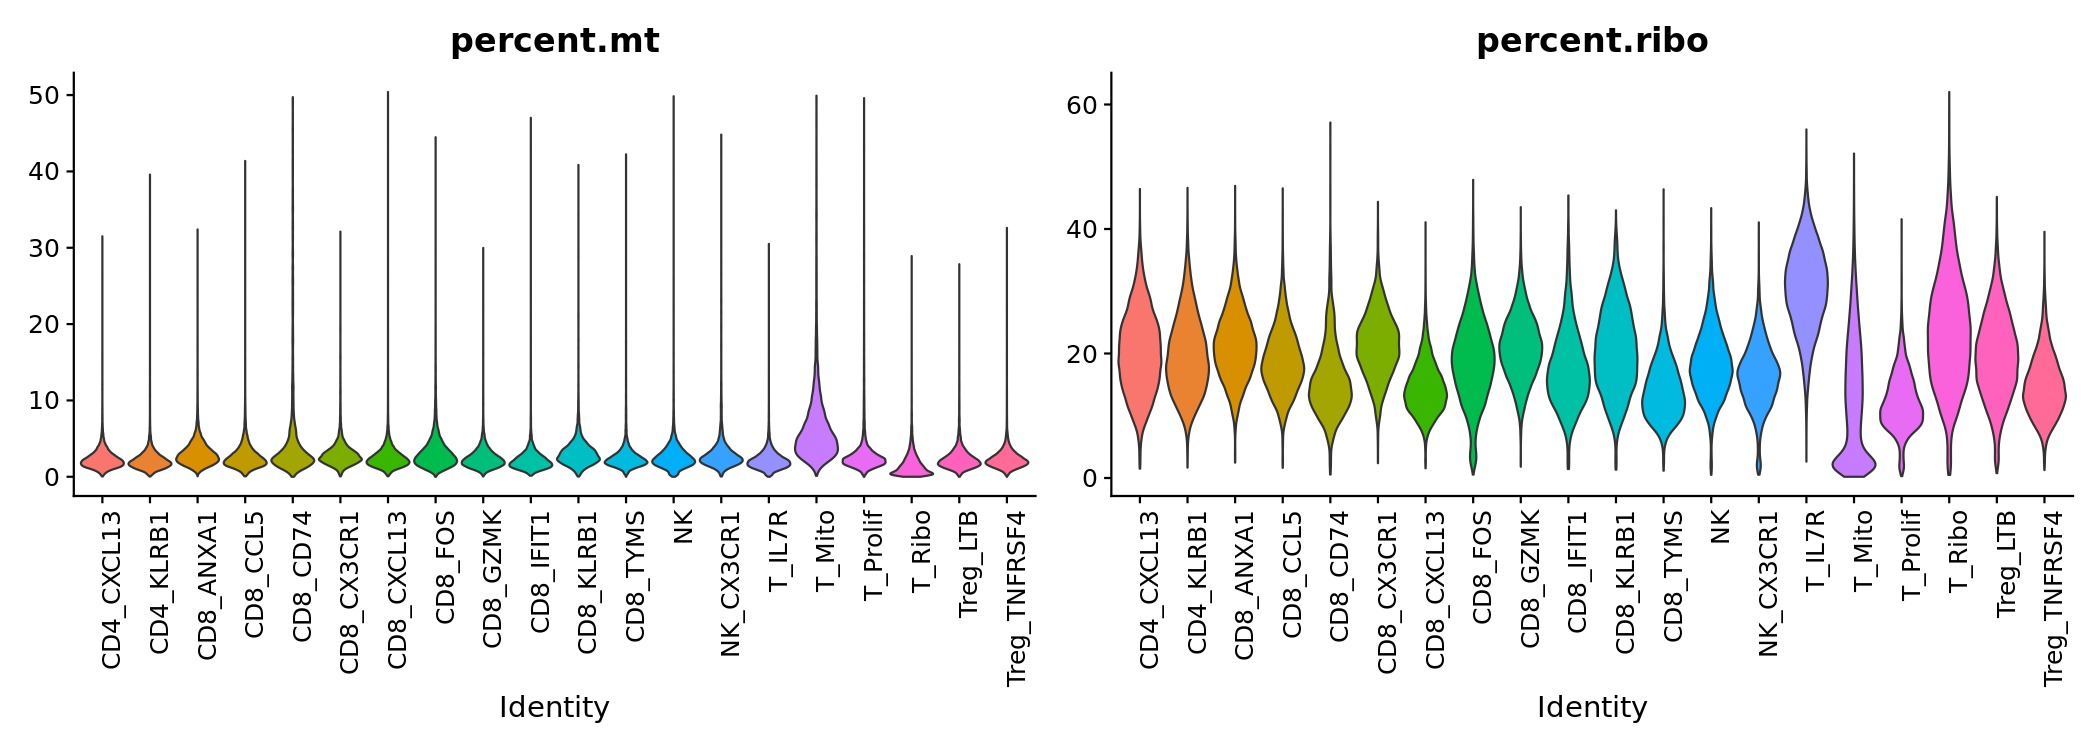

In [132]:
jp_opt(wd = 14, hg = 5)
VlnPlot(scrna, pt.size = 0, group.by = 'subtype', features = c('percent.mt', 'percent.ribo'), ncol = 2) &
NoLegend() &
theme(axis.text.x = element_text(angle = 90))

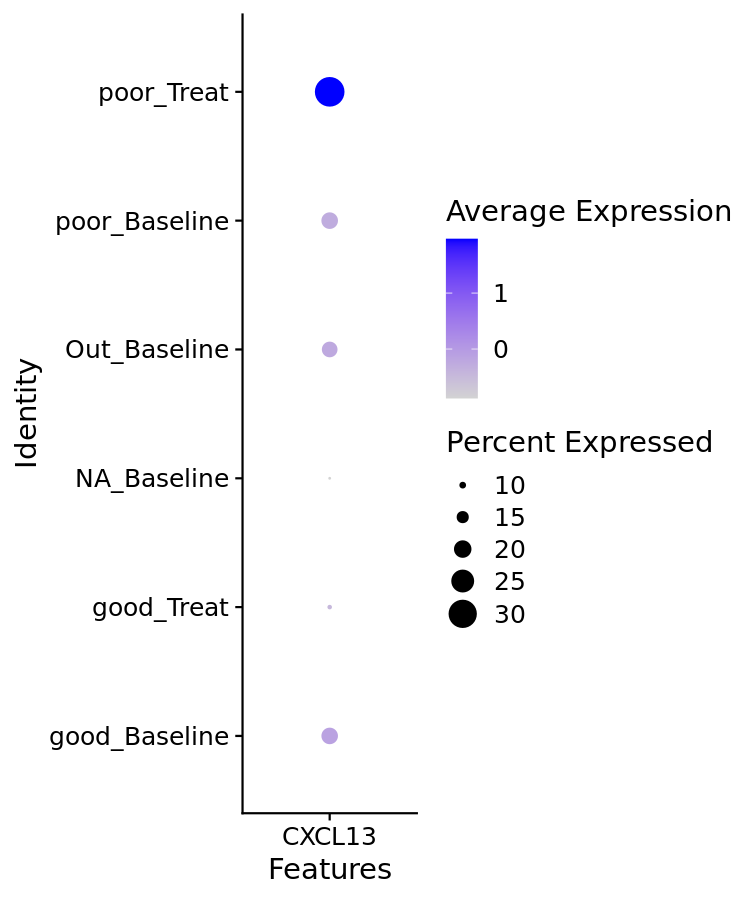

In [ ]:
# f_cell_state <- '../figures/fig3/fig3-net_tcr_sharing-node_info.tsv'
# df <- read_tsv(f_cell_state, show_col_types = F)
# cell_state_map <- split(df$node, df$node_type)

# scrna$cell_state <- scrna$subtype
# for (nm in names(nm)) {
#     scrna$cell_state[scrna$subtype %in% cell_state_map[[nm]]] <- nm
# }
scrna$gp <- paste(scrna$mandard_group, scrna$sample_type, sep = '_')

jp_opt(wd = 5, hg = 6)
DotPlot(scrna, features = 'CXCL13', group.by = 'gp')